# Link Colab with google drive

In [350]:
from src.run_experiment import Experiment, same_seeds
from models.autoencoder import AutoEncoder
from models.clustering import PhaseClassifier
from load_dataset.exhaust import *
from py_widgets.widgets import *

# Make sure that you can always have updated modules/functions from other python files.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset preprocessing

## View the dataset
Load the .bcf file and create an object of `SEMDataset` (which uses hyperspy as backend.)

Something you can do with the `sem` object:
1. `sem.bse`: access the back-scattered electron image.

2. `sem.edx`: access the edx dataset.

3. `plot_sum_spectrum(sem.edx)`: view the sum spectrum (or use hyperspy built-in function `sem.edx.sum().plot(xray_lines=True)`).

4. `sem.feature_list`: view the default chosen elemental peaks in the edx dataset.

5. `sem.set_feature_list`: set new elemental peaks. 


In [2]:
#@markdown ### Enter a file path to load .bcf file:

# Load .bcf file
file_path = '/Users/andrewtung/Documents/Github/bcf_files/XLI_exhaust_011.bcf' #@param {type:"string"}
sem = SEMDataset(file_path)

<Signal2D, title: Ch 0, dimensions: (|739, 672)>
├── Acquisition_instrument
│   └── SEM
│       ├── beam_energy = 15.0
│       └── magnification = 10191.26669
├── General
│   ├── original_filename = XLI_exhaust_011.bcf
│   └── title = Ch 0
├── Sample
│   └── name = Undefinded
└── Signal
    ├── binned = False
    └── signal_type = 



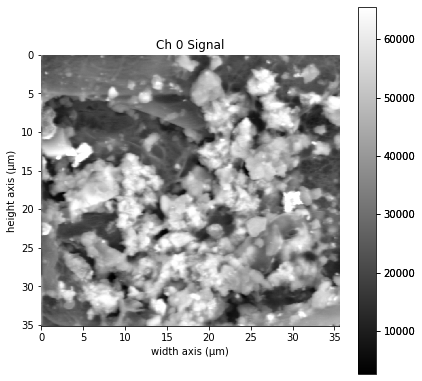

In [3]:
#### @title Check metadata of the dataset { run: "auto" }

dataset = "bse" #@param ["edx", "bse"]

# Check edx dataset
if dataset == "edx":
    print(sem.edx)
    print(sem.edx.metadata)
elif dataset == "bse":
    print(sem.bse)
    print(sem.bse.metadata)
    sem.bse.plot()

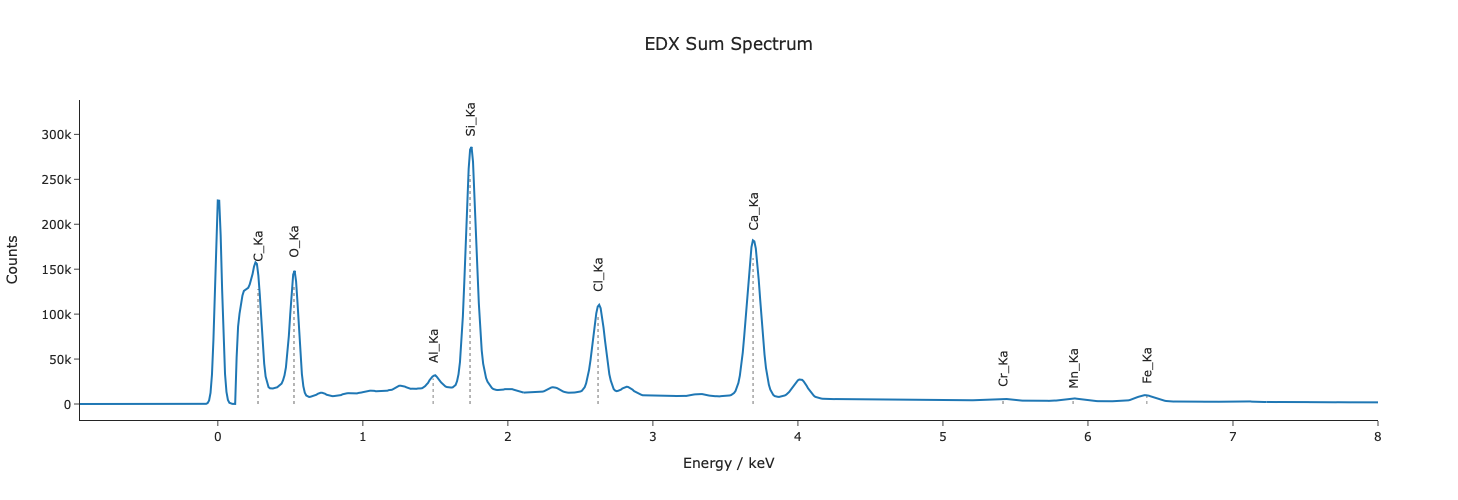

In [4]:
# Or check the sum spectrum using an interactive plot function (written by me).
plot_sum_spectrum(sem.edx)

In [6]:
#@title Identify Energy Peak { run: "auto" }

# Find the peak which hasn't been identified
peak_energy_keV = 1.489 #@param {type:"number"}

hs.eds.get_xray_lines_near_energy(energy=peak_energy_keV, only_lines=['a', 'b'])

['Al_Ka',
 'Br_La',
 'Tm_Mb',
 'Tm_Ma',
 'Yb_Ma',
 'Br_Lb1',
 'Er_Mb',
 'Se_Lb1',
 'Al_Kb',
 'Yb_Mb',
 'Er_Ma',
 'Lu_Ma',
 'Kr_La']

In [324]:
# Check the default elemental peaks
sem.feature_list

['O_Ka',
 'Fe_Ka',
 'Mg_Ka',
 'Ca_Ka',
 'Al_Ka',
 'C_Ka',
 'Si_Ka',
 'S_Ka',
 'Cl_Ka',
 'Cl_Kb',
 'Ca_Kb',
 'Mn_Ka',
 'Cr_Ka',
 'Fe_Kb',
 'Fe_La']

Set feature_list to ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


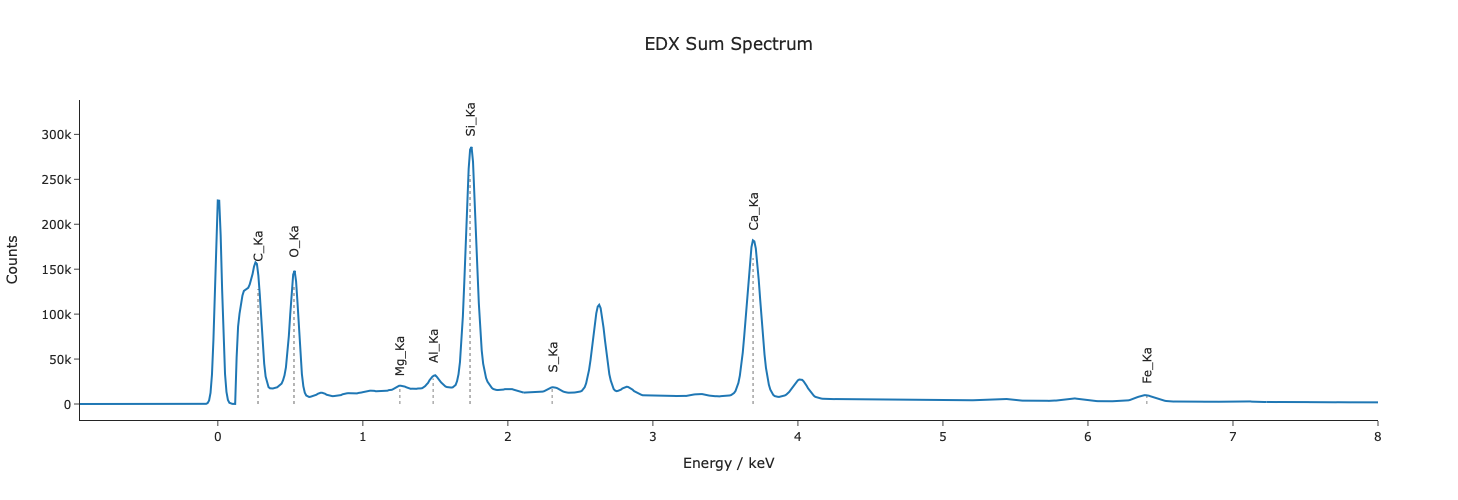

In [328]:
# Change the default elemental peaks
sem.set_feature_list(['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka'])
plot_sum_spectrum(sem.edx)

## Process the dataset
Some useful functions:
1. `sem.rebin_signal(size=(2,2))`: rebin the edx signal with the size of 2x2. After rebinning the dataset, we can access the binned edx or bse data using `sem.edx_bin` or `sem.bse_bin`.

2. `peak_intensity_normalisation(sem.edx_bin)`: normalise the x-ray intensity along energy axis.

3. `remove_fist_peak`: remove the first x-ray peak by calling the function with the argument `end`.

4. `peak_denoising_PCA`: denoise the spectrum using *Principle Component Analysis (PCA)*.

    > `n_components_to_reconstruct`: specify how many components to reconstruct the the EDX intensity profile.

    > `spectrum.plot_results`: True to plot all results.

5. `plot_intensity_maps`: Plot the elemental intensity maps.

In [5]:
# Rebin both edx and bse dataset
sem.rebin_signal(size=(2,2))

Rebinning the intensity with the size of (2, 2)


(<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>,
 <Signal2D, title: Ch 0, dimensions: (|369, 336)>)

In [6]:
# Normalisation along energy axis
peak_intensity_normalisation(sem.edx_bin)

<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>

Removing the fisrt peak by setting the intensity to zero until the energy of 0.1197 keV.


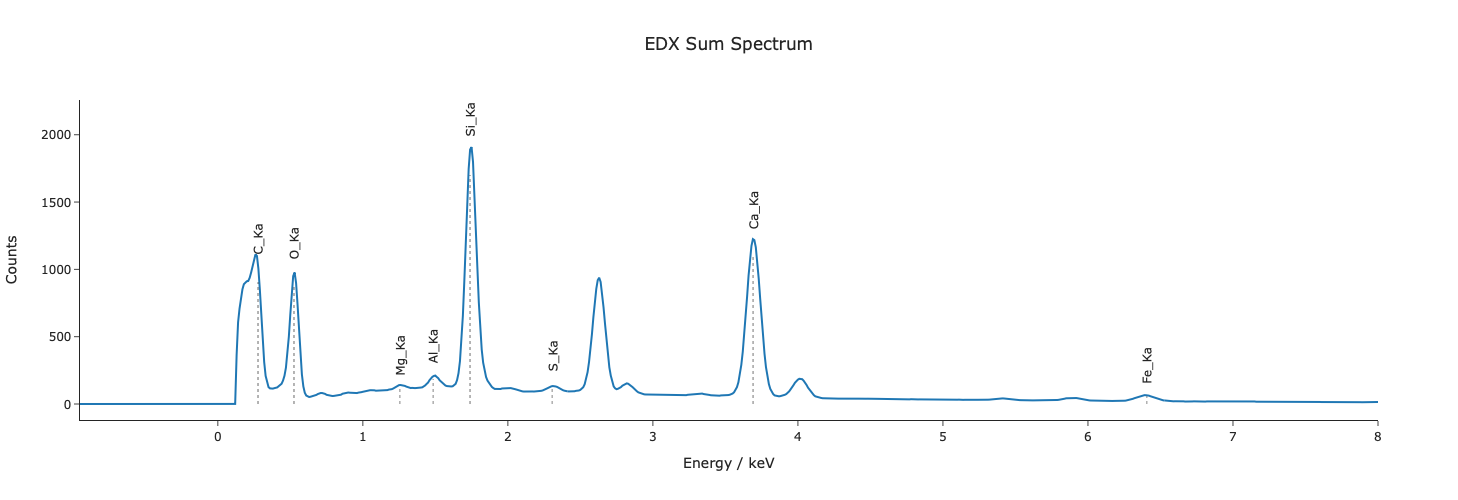

In [10]:
#@title Remove the first peak by seeting the end energy

# Remove the first peak
end_energy = 0.1197 #@param {type:"number"}

sem.remove_fist_peak(end=end_energy) 
plot_sum_spectrum(sem.edx_bin)

In [7]:
# Denoise the X-ray profile using PCA.
peak_denoising_PCA(sem.edx_bin, n_components_to_reconstruct=10, plot_results=False)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=10
  centre=None


<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>

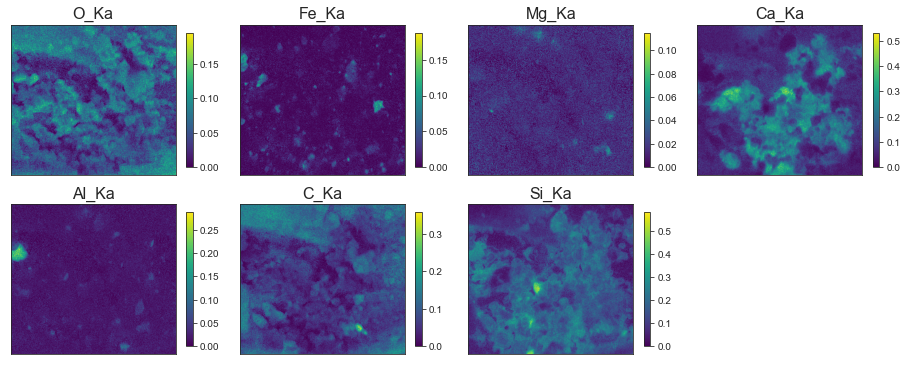

In [240]:
# Plot elemental intensity map
plot_intensity_maps(sem.edx_bin, sem.feature_list[:-1])

## Normalisation

Set feature_list as ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']


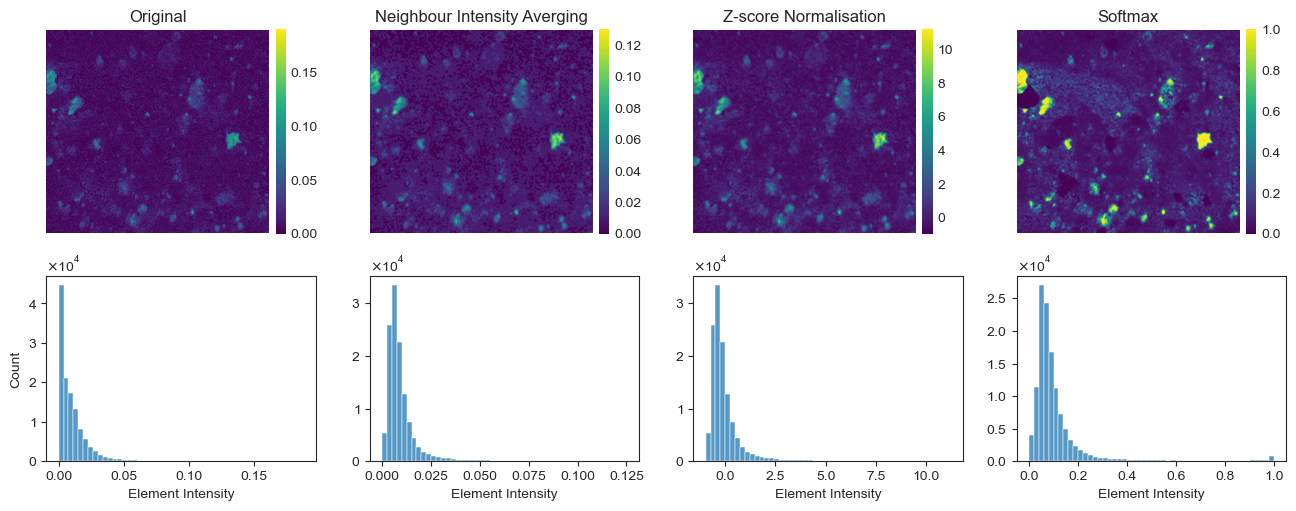

In [8]:
# Get a np.array from the object <sem>, size of dataset should be [336, 369, 8 (num_elements)]
feature_list = ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka']
dataset = sem.get_feature_maps(feature_list)

# Process the dataset by averaging the neighboring intensity
dataset_processed = avgerage_neighboring_signal(dataset)

# Apply z-score normalisation on each intensity map
dataset_norm = z_score_normalisation(dataset_processed)

# Apply softmax along the axis=2 
dataset_softmax = softmax(dataset_norm)

# Plot intensity distributions after (1)avgerage_neighboring_signal; (2)z_score_normalisation; (3) softmax
plot_pixel_distributions(sem, peak='Fe_Ka')

# Autoencoder

## Initialise experiment / model

In [9]:
# Fix the random seed, so that we can reproduce the training if using the same seed.
same_seeds(1)

# Set up the experiment, e.g. determining the model structure, dataset for training etc.
general_results_dir='results' 
EX = Experiment(descriptor='AE_unmix',
                general_results_dir=general_results_dir,
                model=AutoEncoder,
                model_args={'hidden_layer_sizes':(512,256,128)}, # number of hidden layers and corresponding neurons
                chosen_dataset=dataset_softmax,
                save_model_every_epoch=False)

model_name: Model-AE_unmix
size_dataset: (336, 369, 8)
device: cpu
num_parameters: 341770


## Training

In [14]:
# Train the model (Can skip if you want to load the trained model parameters)
EX.run_model(num_epochs=10,
             patience=50, 
             batch_size=64,
             learning_rate=1e-4, 
             weight_decay=0.0, 
             task='train_all', # Change to 'train_all' to train all the dataset without separate some parts for evaluation
             noise_added=0.0,
             lr_scheduler_args={'factor':0.5,
                                'patience':5, 
                                'threshold':1e-2, 
                                'min_lr':1e-7,
                                'verbose':True}) 

num_epochs: 50
batch_size: 64
task: train_all
optimizer: lr=0.0001 and weight_decay=0.0

Start training ...

Epoch 0 ----> model saved, test_loss = 0.002656
[01/50] train_loss: 0.002656, test_loss: 0.000000, time: 42.7 sec
Epoch 1 ----> model saved, test_loss = 0.001573
[02/50] train_loss: 0.001573, test_loss: 0.000000, time: 59.0 sec
Epoch 2 ----> model saved, test_loss = 0.001471
[03/50] train_loss: 0.001471, test_loss: 0.000000, time: 59.7 sec
Epoch 3 ----> model saved, test_loss = 0.001403
[04/50] train_loss: 0.001403, test_loss: 0.000000, time: 65.8 sec
Epoch 4 ----> model saved, test_loss = 0.001363
[05/50] train_loss: 0.001363, test_loss: 0.000000, time: 54.9 sec
Epoch 5 ----> model saved, test_loss = 0.001326
[06/50] train_loss: 0.001326, test_loss: 0.000000, time: 55.6 sec
Epoch 6 ----> model saved, test_loss = 0.001286
[07/50] train_loss: 0.001286, test_loss: 0.000000, time: 44.5 sec
Epoch 7 ----> model saved, test_loss = 0.001262
[08/50] train_loss: 0.001262, test_loss: 0.00

KeyboardInterrupt: 

## Loading model

In [10]:
# Load the trained model file 
EX.load_trained_model('results/2021-10-30_Model-AE_unmix/params/Model-AE_unmix_epoch009')

# Get the dimension-reduced dataset
latent = EX.get_latent()

Loading model parameters from results/2021-10-30_Model-AE_unmix/params/Model-AE_unmix_epoch009


# Gaussian mixture clustering

In [326]:
# Set up an object for GM clustering
PC = PhaseClassifier(latent, 
                     dataset_softmax, 
                     sem, 
                     method='BayesianGaussianMixture', 
                     method_args={'n_components':12, 'random_state':4, 'init_params':'kmeans'})

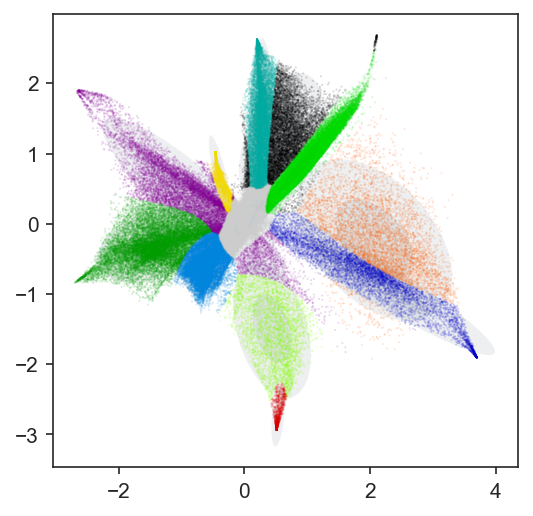

In [12]:
# Plot latent sapce (2-dimensional) with corresponding Gaussian models
PC.plot_latent_space()

In [345]:
PC.set_feature_list(['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka'])
show_cluster_distribution(PC)

SelectMultiple(options=('All', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', '…

Output()

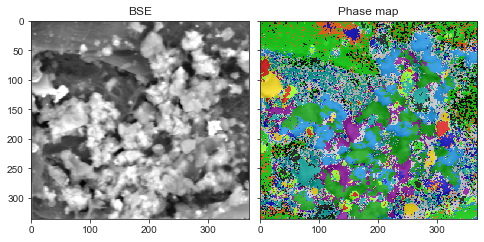

In [346]:
# Plot phase map using the corresponding GM model
PC.plot_phase_map()

In [347]:
# Given a cluster, plot the binary map and the x-ray profile 
# from the corresponding pixels in the binary map.
binary_filter_args={'threshold':0.8, 
                    'denoise':False, 
                    'keep_fraction':0.13, 
                    'binary_filter_threshold':0.5}

In [348]:
show_clusters(PC,binary_filter_args)

SelectMultiple(options=('cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster…

## Statistics of phase properties

In [352]:
from py_widgets.widgets import *
show_cluster_stats(PC,binary_filter_args)

Output()

# Unmix x-ray profiles using Non-negative Matrix Fatorization (NMF)

In [16]:
weights, components = PC.get_unmixed_edx_profile(clusters_to_be_calculated=None,#[0,3,6,7,8,10,11],
                                    normalised=True, method='NMF', 
                                    method_args={'init':'nndsvd'},
                                    binary_filter_args=binary_filter_args)

In [353]:
show_unmixed_weights(weights)

Dropdown(options=('ALL', 'cluster_0', 'cluster_1', 'cluster_10', 'cluster_11', 'cluster_2', 'cluster_3', 'clus…

Output()

Output()

In [39]:
#@title Identify Energy Peak { run: "auto" }

# Find the peak which hasn't been identified
peak_energy_keV = 3.3197 #@param {type:"number"}

hs.eds.get_xray_lines_near_energy(energy=peak_energy_keV, only_lines=['a', 'b'])

['Cd_Lb1', 'K_Ka', 'U_Mb', 'In_La', 'Pa_Mb']

In [256]:
PC.set_feature_list(['O_Ka','Fe_Ka','Mg_Ka','Ca_Ka','Al_Ka','C_Ka',
                  'Si_Ka','S_Ka','Cl_Ka','Cl_Kb','Ca_Kb','Mn_Ka',
                  'Cr_Ka','Fe_Kb', 'Fe_La'])

Set feature_list to ['O_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka', 'S_Ka', 'Cl_Ka', 'Cl_Kb', 'Ca_Kb', 'Mn_Ka', 'Cr_Ka', 'Fe_Kb', 'Fe_La']


In [19]:
show_unmixed_components(PC, components)

Dropdown(options=('ALL', 'cpnt_0', 'cpnt_1', 'cpnt_10', 'cpnt_11', 'cpnt_2', 'cpnt_3', 'cpnt_4', 'cpnt_5', 'cp…

Output()